In [10]:
import os
import sys
os.environ["JAVA_HOME"] = "/Users/jedrzej/Library/Java/JavaVirtualMachines/openjdk-23.0.2/Contents/Home"
os.environ["JDK_JAVA_OPTIONS"] = "-Djava.security.manager=allow"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, avg, hour, floor
from pyspark.sql.functions import to_date, month, dayofmonth, lit, concat_ws
from pyspark.sql import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import IntegerType, DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

In [12]:
spark = SparkSession.builder \
    .appName("ImprovedFlightDelayPrediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "4g") \
    .master("local[*]") \
    .config("spark.driver.extraJavaOptions", "-Dlog4j2.rootLevel=error") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

df = spark.read.csv("Flight_delay.csv", header=True, inferSchema=True)
print(f"Original row count: {df.count()}")
df.printSchema()

NOTE: Picked up JDK_JAVA_OPTIONS: -Djava.security.manager=allow
NOTE: Picked up JDK_JAVA_OPTIONS: -Djava.security.manager=allow
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/04 10:37:18 WARN Utils: Your hostname, Jedrzejs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.128.50.90 instead (on interface en0)
25/12/04 10:37:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/04 10:37:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Original row count: 484551
root
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Org_Airport: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Dest_Airport: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverte

In [13]:
df_clean = df.filter((col("Cancelled") == 0) & (col("Diverted") == 0)) \
             .drop("Cancelled", "Diverted") \
             .withColumn("ArrDelay", col("ArrDelay").cast("double")) \
             .withColumn("DepDelay", col("DepDelay").cast("double"))

df_clean = df_clean.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
df_clean = df_clean.withColumn("Month", month(col("Date")))
df_clean = df_clean.withColumn("Day", dayofmonth(col("Date")))
df_clean = df_clean.withColumn("DepHour", (col("DepTime") / 100).cast("int"))
df_clean = df_clean.withColumn("ArrHour", (col("ArrTime") / 100).cast("int"))
df_clean = df_clean.withColumn("IsWeekend", when(col("DayOfWeek").isin([6, 7]), 1).otherwise(0))

df_clean = df_clean.withColumn("TaxiTotal", col("TaxiIn") + col("TaxiOut"))
df_clean = df_clean.withColumn("ScheduledFlightTime", col("CRSElapsedTime"))
df_clean = df_clean.withColumn("ActualFlightTime", col("ActualElapsedTime"))
df_clean = df_clean.withColumn("FlightTimeDiff", col("ActualElapsedTime") - col("CRSElapsedTime"))
df_clean = df_clean.withColumn("CRSArrHour", floor(col("CRSArrTime") / 100))
df_clean = df_clean.dropna(subset=["ArrDelay", "DepDelay", "UniqueCarrier", "Origin", "Dest"])
print(f"Row count after cleaning: {df_clean.count()}")

Row count after cleaning: 484551


In [14]:
df_clean = df_clean.withColumn("TimeOfDay",
    when(col("DepHour").between(6, 11), "Morning")
    .when(col("DepHour").between(12, 17), "Afternoon")
    .when(col("DepHour").between(18, 21), "Evening")
    .otherwise("Night")
)

df_clean = df_clean.withColumn("DistanceCategory",
    when(col("Distance") < 500, "Short")
    .when(col("Distance").between(500, 1500), "Medium")
    .otherwise("Long")
)

df_clean = df_clean.withColumn("Route",
    concat_ws("-", col("Origin"), col("Dest"))
)

carrier_stats = df_clean.groupBy("UniqueCarrier").agg(
    avg("ArrDelay").alias("AvgCarrierDelay"),
    count("*").alias("CarrierFlightCount")
)
df_clean = df_clean.join(carrier_stats, "UniqueCarrier", "left")

hour_stats = df_clean.groupBy("DepHour").agg(
    avg("ArrDelay").alias("AvgHourDelay")
)
df_clean = df_clean.join(hour_stats, "DepHour", "left")

route_stats = df_clean.groupBy("Route").agg(
    avg("ArrDelay").alias("AvgRouteDelay"),
    count("*").alias("RouteFlightCount")
)
df_clean = df_clean.join(route_stats, "Route", "left")

origin_stats = df_clean.groupBy("Origin").agg(
    avg("ArrDelay").alias("AvgOriginDelay")
)
df_clean = df_clean.join(origin_stats, "Origin", "left")

dest_stats = df_clean.groupBy("Dest").agg(
    avg("ArrDelay").alias("AvgDestDelay")
)
df_clean = df_clean.join(dest_stats, "Dest", "left")

carrier_hour_stats = df_clean.groupBy("UniqueCarrier", "DepHour").agg(
    avg("ArrDelay").alias("AvgCarrierHourDelay")
)
df_clean = df_clean.join(carrier_hour_stats, ["UniqueCarrier", "DepHour"], "left")

df_clean = df_clean.withColumn("IsRushHour",
    when((col("DepHour").between(6, 9)) | (col("DepHour").between(17, 20)), 1)
    .otherwise(0)
)

In [15]:
agg_cols = ["AvgCarrierDelay", "AvgHourDelay", "AvgRouteDelay",
            "AvgOriginDelay", "AvgDestDelay", "AvgCarrierHourDelay"]
for col_name in agg_cols:
    df_clean = df_clean.withColumn(col_name,
        when(col(col_name).isNull(), 0).otherwise(col(col_name))
    )

### FEATURES

In [16]:
numeric_features_no_dep = [
    'DayOfWeek', 'Month', 'Day', 'DepHour', 'IsWeekend', 'IsRushHour',
    'Distance', 'CRSElapsedTime', 'CRSArrHour',
    'AvgCarrierDelay', 'AvgHourDelay', 'AvgRouteDelay',
    'AvgOriginDelay', 'AvgDestDelay', 'AvgCarrierHourDelay',
    'CarrierFlightCount', 'RouteFlightCount'
]


In [17]:
numeric_features_with_dep = numeric_features_no_dep + [
    'DepDelay', 'TaxiOut'
]

In [18]:
categorical_features = ['UniqueCarrier', 'Origin', 'Dest', 'TimeOfDay', 'DistanceCategory']
TARGET = 'ArrDelay'

### Pipelines

In [19]:
def create_pipeline(numeric_features, use_standard_scaler=False):
    stages = []

    for cat_col in categorical_features:
        indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}Index", handleInvalid="keep")
        encoder = OneHotEncoder(inputCol=f"{cat_col}Index", outputCol=f"{cat_col}Vec")
        stages.extend([indexer, encoder])

    assembler_inputs = [f"{c}Vec" for c in categorical_features] + numeric_features
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_raw")
    stages.append(assembler)

    if use_standard_scaler:
        scaler = StandardScaler(inputCol="features_raw", outputCol="features")
    else:
        scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")
    stages.append(scaler)

    return stages

### Data split

In [20]:
all_features = list(set(numeric_features_with_dep + categorical_features + [TARGET]))
df_model = df_clean.select(all_features)

In [21]:
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)
print(f"\nTraining set size: {train_data.count()}")
print(f"Testing set size: {test_data.count()}")


Training set size: 387868


Testing set size: 96683


### Models

In [22]:
models = {
    "Linear Regression": LinearRegression(featuresCol="features", labelCol=TARGET, maxIter=100),
    "Random Forest": RandomForestRegressor(featuresCol="features", labelCol=TARGET,
                                           numTrees=20, maxDepth=10, seed=42),
    "GBT Regressor": GBTRegressor(featuresCol="features", labelCol=TARGET,
                                  maxIter=100, maxDepth=7, seed=42)
}

In [23]:
evaluator_rmse = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="r2")

In [24]:
results_a = []
best_model_a = None
best_r2_a = -float('inf')
best_model_name_a = ""
best_predictions_a = None

In [25]:
results_b = []
best_model_b = None
best_r2_b = -float('inf')
best_model_name_b = ""
best_predictions_b = None

In [26]:
pipeline_stages_a = create_pipeline(numeric_features_no_dep, use_standard_scaler=False)
pipeline_stages_b = create_pipeline(numeric_features_with_dep, use_standard_scaler=False)

#### Model A

In [27]:
for name, model in models.items():
    print(f"\nTraining {name}...")

    model_pipeline = Pipeline(stages=pipeline_stages_a + [model])
    model_fit = model_pipeline.fit(train_data)
    predictions = model_fit.transform(test_data)

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    print(f"{name} Results:")
    print(f"RMSE:{rmse:.4f}")
    print(f"MAE:{mae:.4f}")
    print(f"R2:{r2:.4f}")

    results_a.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

    if r2 > best_r2_a:
        best_r2_a = r2
        best_model_a = model_fit
        best_model_name_a = name
        best_predictions_a = predictions

print(f"Best Model A: {best_model_name_a} with R2: {best_r2_a:.4f}")


Training Linear Regression...


Linear Regression Results:
RMSE:52.2277
MAE:34.1944
R2:0.1500

Training Random Forest...


Random Forest Results:
RMSE:40.0856
MAE:27.7550
R2:0.4993

Training GBT Regressor...


GBT Regressor Results:
RMSE:30.2824
MAE:21.1137
R2:0.7143
Best Model A: GBT Regressor with R2: 0.7143


In [28]:
for name, model in models.items():
    print(f"\nTraining {name}...")

    model_pipeline = Pipeline(stages=pipeline_stages_b + [model])
    model_fit = model_pipeline.fit(train_data)
    predictions = model_fit.transform(test_data)

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    print(f"{name} Results:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R2:   {r2:.4f}")

    results_b.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

    if r2 > best_r2_b:
        best_r2_b = r2
        best_model_b = model_fit
        best_model_name_b = name
        best_predictions_b = predictions

print(f"Best Model B: {best_model_name_b} with R2: {best_r2_b:.4f}")


Training Linear Regression...


Linear Regression Results:
  RMSE: 10.7363
  MAE:  7.4543
  R2:   0.9641

Training Random Forest...


Random Forest Results:
  RMSE: 18.0451
  MAE:  10.3311
  R2:   0.8985

Training GBT Regressor...


GBT Regressor Results:
  RMSE: 14.6920
  MAE:  8.4039
  R2:   0.9327
Best Model B: Linear Regression with R2: 0.9641


### Model comparasing

In [29]:
results_df_a = pd.DataFrame(results_a)
results_df_a['Type'] = 'Model A (bez DepDelay)'

results_df_b = pd.DataFrame(results_b)
results_df_b['Type'] = 'Model B (z DepDelay)'

results_combined = pd.concat([results_df_a, results_df_b])

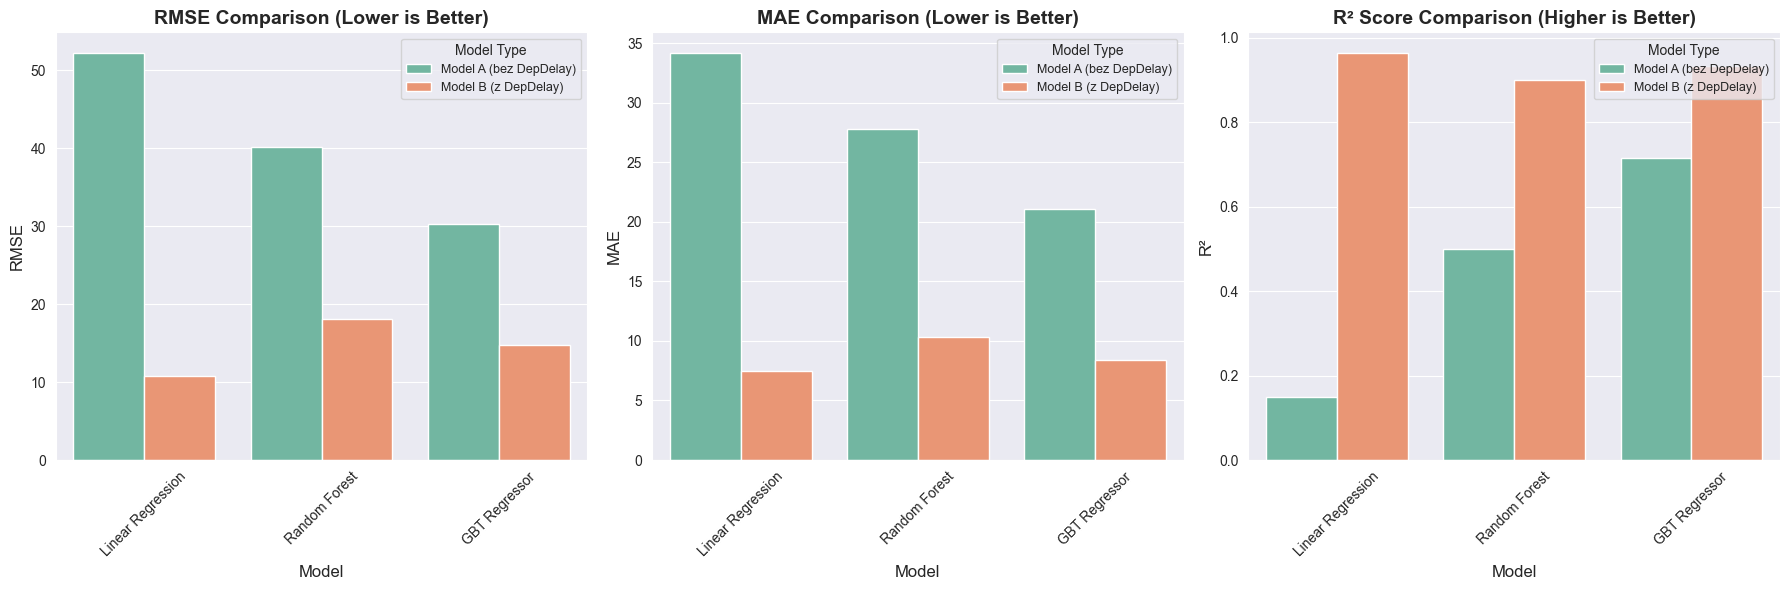

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE
sns.barplot(data=results_combined, x="Model", y="RMSE", hue="Type", ax=axes[0], palette="Set2")
axes[0].set_title("RMSE Comparison (Lower is Better)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Model", fontsize=12)
axes[0].set_ylabel("RMSE", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Model Type', fontsize=9)

# MAE
sns.barplot(data=results_combined, x="Model", y="MAE", hue="Type", ax=axes[1], palette="Set2")
axes[1].set_title("MAE Comparison (Lower is Better)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Model", fontsize=12)
axes[1].set_ylabel("MAE", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Model Type', fontsize=9)

# R2
sns.barplot(data=results_combined, x="Model", y="R2", hue="Type", ax=axes[2], palette="Set2")
axes[2].set_title("R² Score Comparison (Higher is Better)", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Model", fontsize=12)
axes[2].set_ylabel("R²", fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title='Model Type', fontsize=9)

plt.tight_layout()
plt.show()

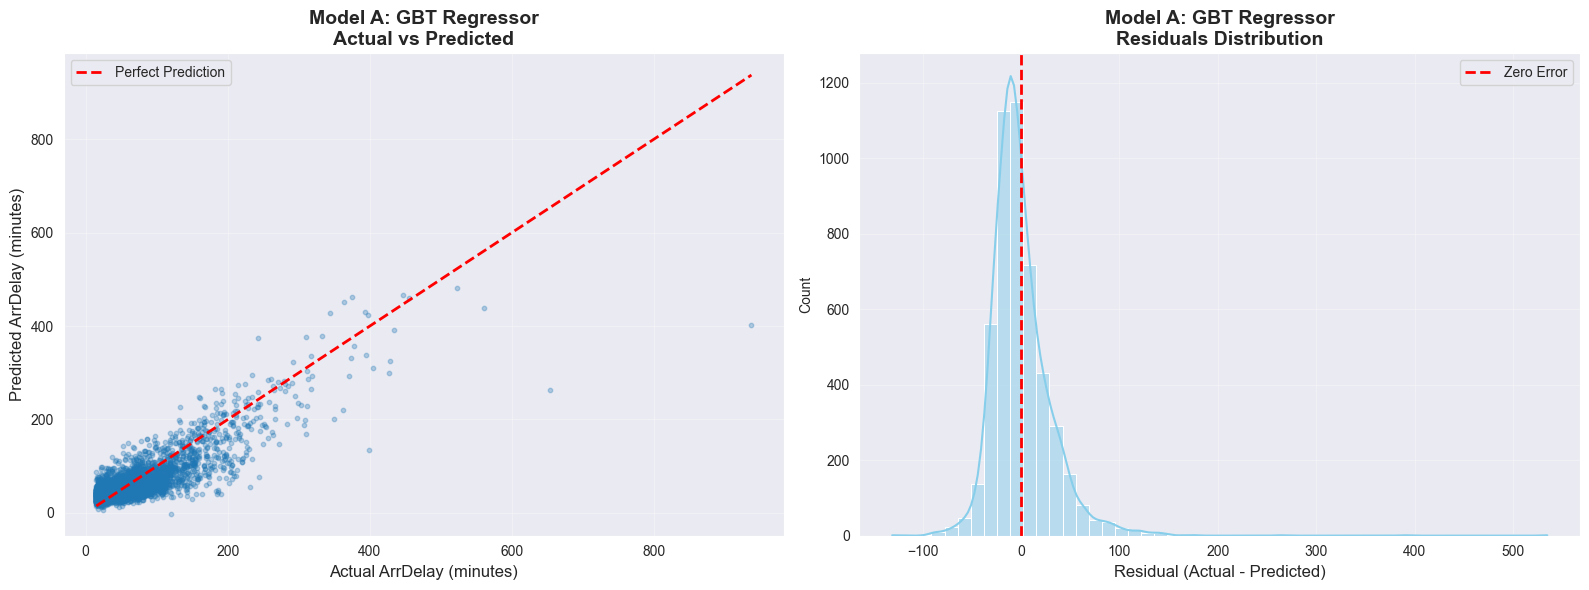

In [31]:
sample_preds_a = best_predictions_a.select(TARGET, "prediction").sample(False, 0.05, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(sample_preds_a[TARGET], sample_preds_a["prediction"], alpha=0.3, s=10)
axes[0].plot([sample_preds_a[TARGET].min(), sample_preds_a[TARGET].max()],
             [sample_preds_a[TARGET].min(), sample_preds_a[TARGET].max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("Actual ArrDelay (minutes)", fontsize=12)
axes[0].set_ylabel("Predicted ArrDelay (minutes)", fontsize=12)
axes[0].set_title(f"Model A: {best_model_name_a}\nActual vs Predicted", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
sample_preds_a["Residuals"] = sample_preds_a[TARGET] - sample_preds_a["prediction"]
sns.histplot(sample_preds_a["Residuals"], kde=True, bins=50, ax=axes[1], color='skyblue')
axes[1].set_title(f"Model A: {best_model_name_a}\nResiduals Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Residual (Actual - Predicted)", fontsize=12)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

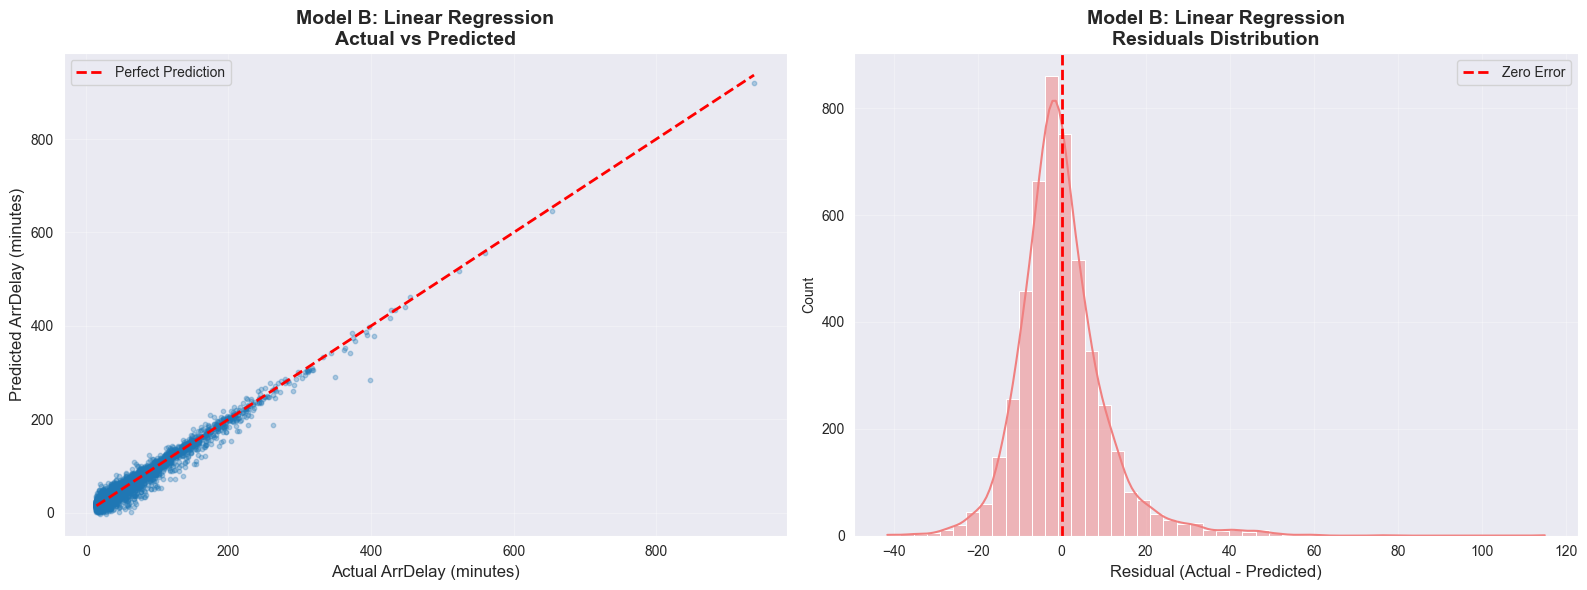

In [32]:
sample_preds_b = best_predictions_b.select(TARGET, "prediction").sample(False, 0.05, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(sample_preds_b[TARGET], sample_preds_b["prediction"], alpha=0.3, s=10)
axes[0].plot([sample_preds_b[TARGET].min(), sample_preds_b[TARGET].max()],
             [sample_preds_b[TARGET].min(), sample_preds_b[TARGET].max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("Actual ArrDelay (minutes)", fontsize=12)
axes[0].set_ylabel("Predicted ArrDelay (minutes)", fontsize=12)
axes[0].set_title(f"Model B: {best_model_name_b}\nActual vs Predicted", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
sample_preds_b["Residuals"] = sample_preds_b[TARGET] - sample_preds_b["prediction"]
sns.histplot(sample_preds_b["Residuals"], kde=True, bins=50, ax=axes[1], color='lightcoral')
axes[1].set_title(f"Model B: {best_model_name_b}\nResiduals Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Residual (Actual - Predicted)", fontsize=12)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Importance

In [33]:
if "Random Forest" in best_model_name_a:
    rf_model = best_model_a.stages[-1]
    feature_names = [f"{c}Vec" for c in categorical_features] + numeric_features_no_dep

    importances = rf_model.featureImportances.toArray()
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top 20 Feature Importance - {best_model_name_a} (Model A)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 najważniejszych cech:")
    print(feature_importance_df.head(10).to_string(index=False))

### Cross Validation

In [36]:
gbt = GBTRegressor(featuresCol="features", labelCol=TARGET, seed=42)
pipeline = Pipeline(stages=pipeline_stages_a + [gbt])

model_baseline = pipeline.fit(train_data)
preds_baseline = model_baseline.transform(test_data)

evaluator = RegressionEvaluator(labelCol=TARGET, predictionCol="prediction", metricName="rmse")

rmse_baseline = evaluator.evaluate(preds_baseline)

print(f"   -> RMSE Baseline: {rmse_baseline:.4f}")


print("\nRozpoczynamy strojenie")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [20, 50, 100]) \
    .addGrid(gbt.maxDepth, [4, 6]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_data)

25/12/04 11:01:36 ERROR Executor: Exception in task 5.0 in stage 8458.0 (TID 62463)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.Integer.valueOf(Integer.java:1019)
	at scala.runtime.java8.JFunction2$mcIII$sp.apply(JFunction2$mcIII$sp.scala:17)
	at scala.collection.ArrayOps$.scanLeft$extension(ArrayOps.scala:824)
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:64)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22(RandomForest.scala:653)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22$adapted(RandomForest.scala:649)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda/0x000003f8022df800.apply(Unknown Source)
	at scala.Array$.tabulate(Array.scala:441)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$21(RandomForest.scala:649)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda/0x000003f8022e1000.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anon

Py4JJavaError: An error occurred while calling o25258.evaluate.
: org.apache.spark.SparkException: Job 3134 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1301)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1299)
	at scala.collection.mutable.HashSet$Node.foreach(HashSet.scala:450)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:376)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1299)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3234)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:85)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:3120)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1300)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:3120)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2346)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1300)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2346)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2297)
	at org.apache.spark.SparkContext.$anonfun$new$36(SparkContext.scala:704)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:231)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:205)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1937)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:205)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:205)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:184)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:572)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:317)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1575)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:469)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.$anonfun$relationFuture$1(BroadcastExchangeExec.scala:182)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$4(SQLExecution.scala:322)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$3(SQLExecution.scala:320)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:316)
	at java.base/java.util.concurrent.CompletableFuture$AsyncSupply.run(CompletableFuture.java:1812)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1575)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1439)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:266)
	at org.apache.spark.sql.classic.Dataset.materializedRdd$lzycompute(Dataset.scala:1578)
	at org.apache.spark.sql.classic.Dataset.materializedRdd(Dataset.scala:1576)
	at org.apache.spark.sql.classic.Dataset.$anonfun$rdd$1(Dataset.scala:1586)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withNewRDDExecutionId$1(Dataset.scala:2221)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:125)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:295)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:124)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:237)
	at org.apache.spark.sql.classic.Dataset.withNewRDDExecutionId(Dataset.scala:2219)
	at org.apache.spark.sql.classic.Dataset.rdd$lzycompute(Dataset.scala:1586)
	at org.apache.spark.sql.classic.Dataset.rdd(Dataset.scala:1584)
	at org.apache.spark.ml.evaluation.RegressionEvaluator.getMetrics(RegressionEvaluator.scala:125)
	at org.apache.spark.ml.evaluation.RegressionEvaluator.evaluate(RegressionEvaluator.scala:98)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:103)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1575)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1301)
		at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1299)
		at scala.collection.mutable.HashSet$Node.foreach(HashSet.scala:450)
		at scala.collection.mutable.HashSet.foreach(HashSet.scala:376)
		at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1299)
		at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3234)
		at org.apache.spark.util.EventLoop.stop(EventLoop.scala:85)
		at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:3120)
		at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1300)
		at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:3120)
		at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2346)
		at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1300)
		at org.apache.spark.SparkContext.stop(SparkContext.scala:2346)
		at org.apache.spark.SparkContext.stop(SparkContext.scala:2297)
		at org.apache.spark.SparkContext.$anonfun$new$36(SparkContext.scala:704)
		at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:231)
		at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:205)
		at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
		at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1937)
		at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:205)
		at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:205)
		at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:184)
		at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:572)
		at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:317)
		at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
		at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
		at java.base/java.lang.Thread.run(Thread.java:1575)
		at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
		at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
		at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
		at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
		at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
		at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
		at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
		at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
		at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
		at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
		at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:469)
		at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.$anonfun$relationFuture$1(BroadcastExchangeExec.scala:182)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$4(SQLExecution.scala:322)
		at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$3(SQLExecution.scala:320)
		at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:316)
		at java.base/java.util.concurrent.CompletableFuture$AsyncSupply.run(CompletableFuture.java:1812)
		at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
		at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
		... 1 more


In [67]:
best_model = cvModel.bestModel
best_gbt = best_model.stages[-1]

preds_tuned = best_model.transform(test_data)
rmse_tuned = evaluator.evaluate(preds_tuned)

print(f"\n3. Wyniki strojenia:")
print(f"   -> RMSE Tuned:    {rmse_tuned:.4f}")
print(f"   -> POPRAWA O:     {rmse_baseline - rmse_tuned:.4f} ({(1 - rmse_tuned/rmse_baseline)*100:.2f}%)")

print("\nNAJLEPSZE PARAMETRY:")
print(f"   - Liczba iteracji (drzew): {best_gbt.getMaxIter()}")
print(f"   - Głębokość (MaxDepth):    {best_gbt.getOrDefault('maxDepth')}")


3. Wyniki strojenia:
   -> RMSE Tuned:    40.6351
   -> POPRAWA O:     10.4649 (20.48%)

NAJLEPSZE PARAMETRY:
   - Liczba drzew (NumTrees): 20
   - Głębokość (MaxDepth):    10


/var/folders/dk/jww3fh693dg2b9_ksjhpzs400000gn/T/ipykernel_9270/1691087015.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='RMSE', data=results_df, palette=['gray', '#10b981'])


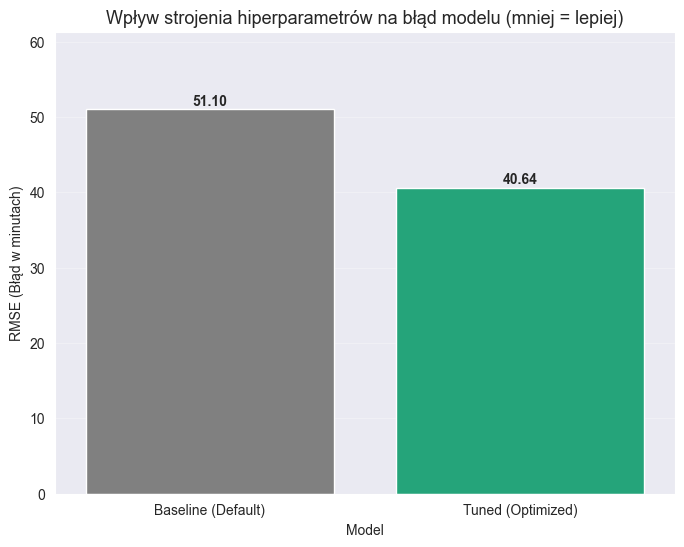

In [68]:
results_df = pd.DataFrame({
    'Model': ['Baseline (Default)', 'Tuned (Optimized)'],
    'RMSE': [rmse_baseline, rmse_tuned]
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='RMSE', data=results_df, palette=['gray', '#3b82f6']) # Niebieski dla GBT

for i, v in enumerate(results_df['RMSE']):
    ax.text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold')

plt.title('GBT: Wpływ strojenia hiperparametrów', fontsize=13)
plt.ylabel('RMSE (Błąd w minutach)')
plt.ylim(0, max(rmse_baseline, rmse_tuned) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Save results

In [69]:
if best_model_a is not None:
    try:
        best_model_a.write().overwrite().save("model_a_gbt")
        print("Model A saved to: model_a_gbt/")
    except Exception as e:
        print(f"Error saving Model A: {e}")


if best_model_b is not None:
    try:
        best_model_b.write().overwrite().save("model_b_lr")
        print("Model B saved to: model_b_lr/")
    except Exception as e:
        print(f"Error saving Model B: {e}")

Model A saved to: model_a_gbt/
Model B saved to: model_b_lr/


In [70]:
stats_to_save = {
    'carrier_stats': carrier_stats.toPandas().set_index('UniqueCarrier')['AvgCarrierDelay'].to_dict(),
    'hour_stats': hour_stats.toPandas().set_index('DepHour')['AvgHourDelay'].to_dict(),
    'route_stats': route_stats.toPandas().set_index('Route')['AvgRouteDelay'].to_dict(),
    'origin_stats': origin_stats.toPandas().set_index('Origin')['AvgOriginDelay'].to_dict(),
    'dest_stats': dest_stats.toPandas().set_index('Dest')['AvgDestDelay'].to_dict(),
}

In [71]:
carrier_hour_dict = {}
try:
    for row in carrier_hour_stats.toPandas().itertuples():
        key = f"{row.UniqueCarrier}_{row.DepHour}"
        carrier_hour_dict[key] = row.AvgCarrierHourDelay
    stats_to_save['carrier_hour_stats'] = carrier_hour_dict
except Exception as e:
    print(f"Błąd przy przetwarzaniu carrier_hour_stats: {e}")

In [72]:
try:
    routes_df = df.select("Origin", "Dest", "Distance").dropna().distinct()

    route_distances = {}
    rows = routes_df.collect()

    for row in rows:
        key = f"{row.Origin}-{row.Dest}"
        route_distances[key] = int(row.Distance)

    stats_to_save['route_distances'] = route_distances
    print(f"Zapisano mapę odległości ({len(route_distances)} tras).")
except Exception as e:
    print(f"Błąd przy generowaniu mapy tras: {e}")
    stats_to_save['route_distances'] = {}

Zapisano mapę odległości (3377 tras).


In [73]:
with open('aggregated_stats.pkl', 'wb') as f:
    pickle.dump(stats_to_save, f)

In [74]:
spark.stop()